In [3]:
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
def PlotParameters(model):
    W = model.state_dict()['Linear.weight'].data
    w_min = W.min().item()
    w_max = W.max().item()
    fig, axes = plt.subplots(2, 5)
    fig.subplots_adjust(hspace=0.01, wspace=0.1)
    for i, ax in enumerate(axes.flat):
        if i < 10:
            ax.set_label('class: {0}'.format(i))
            ax.imshow(W[i, :].view(28, 28), vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_yticks([])
            ax.set_xticks([])
            
    plt.show()

In [18]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))

In [7]:
train_ds = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
print(train_ds)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [12]:
val_ds = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
print(val_ds)

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


4th Image: None


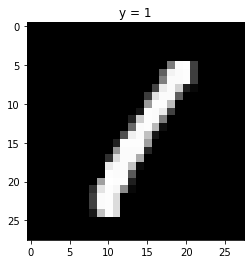

In [30]:
print('4th Image:', show_data(train_ds[3]))

In [31]:
class Softmax(nn.Module):
    def __init__(self, input_size, output_size):
        super(Softmax, self).__init__()
        self.Linear = nn.Linear(input_size, output_size)
        
    def forward(self, x):
        return self.Linear(x)

In [33]:
train_ds[0][0].shape

torch.Size([1, 28, 28])

In [34]:
input_dim = 28 * 28
output_dim = 10

In [35]:
model = Softmax(input_dim, output_dim)
model.state_dict()

OrderedDict([('Linear.weight',
              tensor([[ 0.0180, -0.0192, -0.0250,  ..., -0.0250, -0.0137,  0.0254],
                      [ 0.0237,  0.0098,  0.0138,  ...,  0.0307, -0.0257, -0.0302],
                      [-0.0303, -0.0143,  0.0248,  ..., -0.0327,  0.0151,  0.0244],
                      ...,
                      [ 0.0102, -0.0223, -0.0107,  ...,  0.0057, -0.0222, -0.0200],
                      [ 0.0321,  0.0083,  0.0142,  ..., -0.0046,  0.0178, -0.0157],
                      [-0.0340, -0.0136,  0.0329,  ...,  0.0313, -0.0147,  0.0232]])),
             ('Linear.bias',
              tensor([ 0.0300, -0.0219,  0.0155,  0.0307, -0.0286,  0.0274, -0.0341, -0.0097,
                       0.0184,  0.0083]))])

In [36]:
print(model.state_dict()['Linear.weight'].shape)
print(model.state_dict()['Linear.bias'].shape)

torch.Size([10, 784])
torch.Size([10])


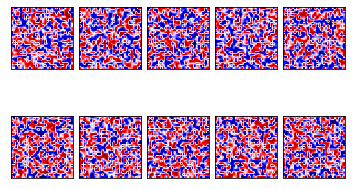

In [41]:
PlotParameters(model)

In [43]:
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(dataset=train_ds, batch_size=100)
val_loader = DataLoader(dataset=val_ds, batch_size=5000)

In [44]:
n_epochs = 10
loss_arr = []
accuracy_arr = []

def train_model(n_epochs):
    for epoch in range(n_epochs):
        for x_train, y_train in train_loader:
            y_hat = model(x_train.view(-1, 28 * 28))
            loss = criterion(y_hat, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        correct = 0
        for x_test, y_test in val_loader:
            z = model(x_test.view(-1, 28 * 28))
            _, y_pred = torch.max(z.data, 1)
            correct += (y_pred == y_test).sum().item()
        accuracy = correct / len(val_ds)
        loss_arr.append(loss.data)
        accuracy_arr.append(accuracy)

In [45]:
train_model(n_epochs)
model.state_dict()

OrderedDict([('Linear.weight',
              tensor([[ 0.0180, -0.0192, -0.0250,  ..., -0.0250, -0.0137,  0.0254],
                      [ 0.0237,  0.0098,  0.0138,  ...,  0.0307, -0.0257, -0.0302],
                      [-0.0303, -0.0143,  0.0248,  ..., -0.0327,  0.0151,  0.0244],
                      ...,
                      [ 0.0102, -0.0223, -0.0107,  ...,  0.0057, -0.0222, -0.0200],
                      [ 0.0321,  0.0083,  0.0142,  ..., -0.0046,  0.0178, -0.0157],
                      [-0.0340, -0.0136,  0.0329,  ...,  0.0313, -0.0147,  0.0232]])),
             ('Linear.bias',
              tensor([-0.3901,  0.3534,  0.1382, -0.2711,  0.0078,  1.3875, -0.1177,  0.6716,
                      -1.4920, -0.2515]))])

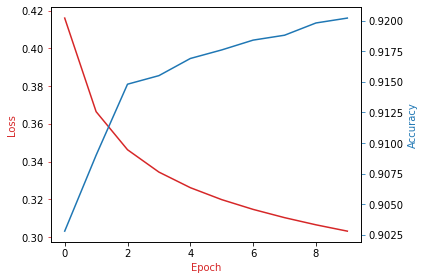

In [46]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss_arr, color=color)
ax1.set_xlabel('Epoch', color=color)
ax1.set_ylabel('Loss', color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(accuracy_arr, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

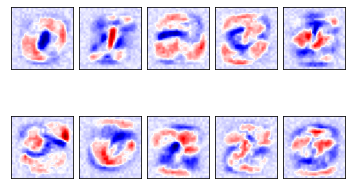

In [47]:
PlotParameters(model)

In [55]:
# Plot the misclassified samples
Softmax_fn = nn.Softmax(dim=-1)
def plot_softmax(errors=True):
    count = 0
    for x, y in val_ds: # First 5 errors
        z = model(x.view(-1, 28 * 28))
        _, y_hat = torch.max(z.data, 1)
        if (y_hat != y and errors) or (y_hat == y and not errors):
            show_data((x, y))
            plt.show()
            print('yhat:', y_hat)
            print('Confidence:', torch.max(Softmax_fn(z)).item())
            count += 1
        if count >= 5:
            break

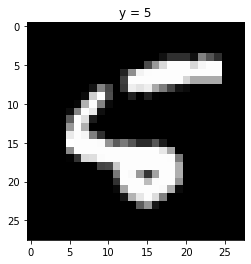

yhat: tensor([6])
Confidence: 0.9902413487434387


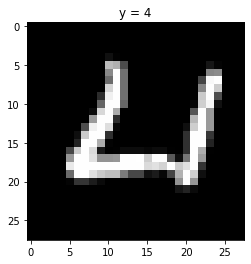

yhat: tensor([6])
Confidence: 0.4394712448120117


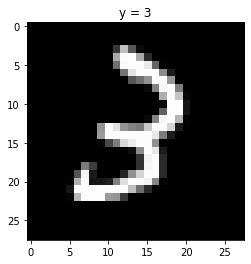

yhat: tensor([2])
Confidence: 0.6819281578063965


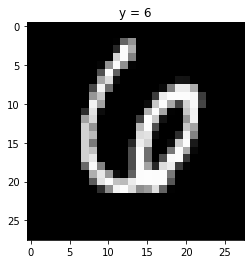

yhat: tensor([7])
Confidence: 0.3437439501285553


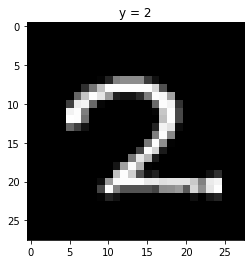

yhat: tensor([7])
Confidence: 0.5451018214225769


In [56]:
plot_softmax()

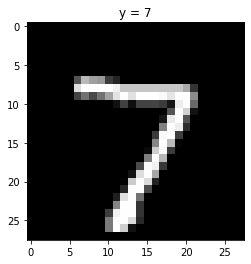

yhat: tensor([7])
Confidence: 0.9967765212059021


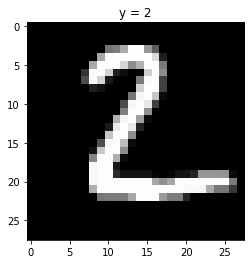

yhat: tensor([2])
Confidence: 0.9490862488746643


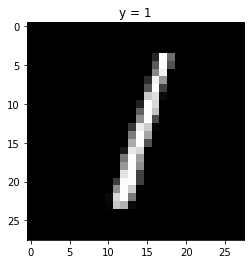

yhat: tensor([1])
Confidence: 0.9749583601951599


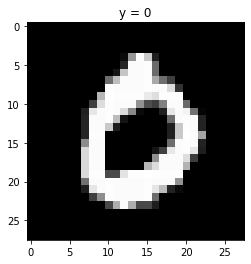

yhat: tensor([0])
Confidence: 0.9995943903923035


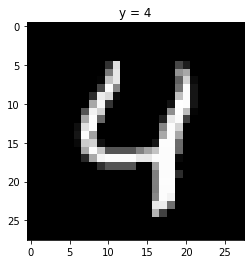

yhat: tensor([4])
Confidence: 0.9494919776916504


In [57]:
plot_softmax(False)